In [1]:
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive/Quora-Questions/"

Mounted at /content/drive
 new_boolq.jsonl   quora_train.csv  'test (1).csv'   train.csv.zip
 quora_test.csv    results	     test.csv	     wiki-news-300d-1M.vec.zip


In [2]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re
!pip install fuzzywuzzy
!pip install sentence_transformers
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import nltk
import time
from matplotlib.pyplot import figure
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
# import optuna
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import warnings
import gc
from sklearn.model_selection import cross_val_score
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

     |████████████████████████████████| 79 kB 3.7 MB/s 
     |████████████████████████████████| 4.0 MB 10.9 MB/s 
     |████████████████████████████████| 1.2 MB 49.2 MB/s 
     |████████████████████████████████| 77 kB 5.9 MB/s 
     |████████████████████████████████| 596 kB 50.0 MB/s 
     |████████████████████████████████| 895 kB 42.3 MB/s 
     |████████████████████████████████| 6.5 MB 37.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=28b676900fd02caf8b9a2b567c2920b25c7281e16209ed647ca40127c100ac40
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
data = pd.read_csv('/content/drive/My Drive/Quora-Questions/quora_train.csv')
test = pd.read_csv('/content/drive/My Drive/Quora-Questions/quora_test.csv')
test

,question1_final,question2_final,is_duplicate,q1_word_num,q2_word_num,total_word_num,differ_word_num,same_first_word,same_last_word,common_word_num,fuzz_ratio
0,why is it that i am skinny but have a big stomach,why did my dietician say i can not have magnes...,0,12,26,38,14,1,0,7,34
1,how do you program quadcopters,can java be used to program a quadcopter,0,5,8,13,3,0,0,1,57
2,what is baking soda used for in cookies,why is baking soda used in cookies,1,8,7,15,1,0,1,6,90
3,what skills are needed to become a film critic,how can an individual become an online film cr...,1,9,9,18,0,0,1,3,60
4,what is the best way to stop loving someone wh...,how do i stop loving someone who loves you back,1,14,10,24,4,0,1,6,72
...,...,...,...,...,...,...,...,...,...,...,...
121282,hypothetically is it possible to light fire i...,is it possible to collect gas molecules from o...,0,10,10,20,0,0,1,6,61
121283,when will xiaomi redmi note 3 be available on ...,is the marketing strategy of xiaomi redmi note...,0,10,10,20,0,0,0,4,49
121284,where can i meet people from other countries o...,how do you meet people from your country when...,0,11,13,24,2,0,0,3,59
121285,is this move of banning 500 1k rupee notes r...,what are your views on demonetization of 500 a...,1,10,16,26,6,0,0,5,49


0    0.62999
1    0.37001
Name: is_duplicate, dtype: float64


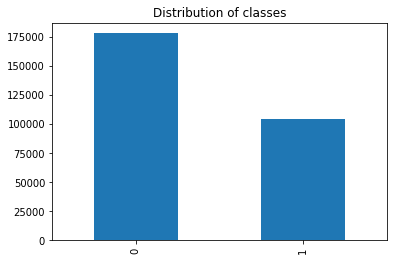

In [4]:
duplicate_value_counts = data.is_duplicate.value_counts()
print(duplicate_value_counts/duplicate_value_counts.sum())
plt.title('Distribution of classes')
duplicate_value_counts.plot.bar()

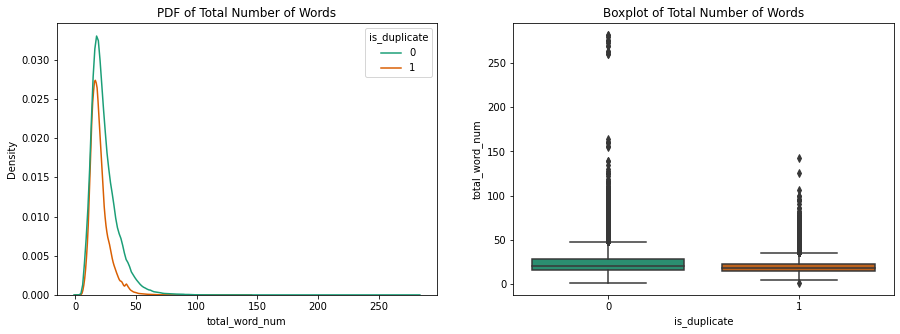

In [9]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Total Number of Words')
sns.kdeplot(data['total_word_num'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Total Number of Words')
sns.boxplot(x=data.is_duplicate, y=data['total_word_num'], palette="Dark2", ax=ax[1])
plt.show()

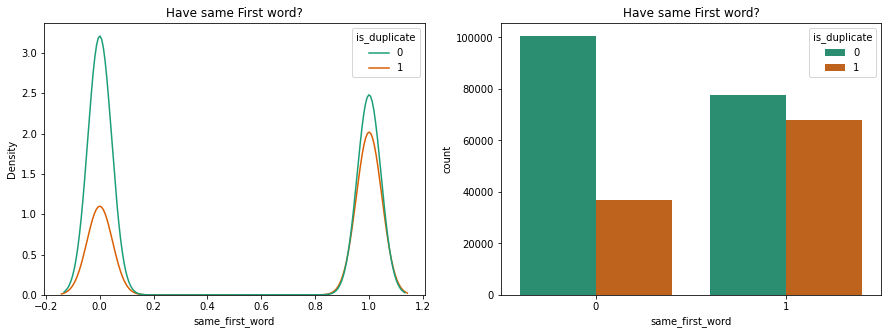

In [10]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Have same First word?')
sns.kdeplot(data['same_first_word'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Have same First word?')
sns.countplot(x=data['same_first_word'], hue=data.is_duplicate, palette="Dark2", ax=ax[1])
plt.show()

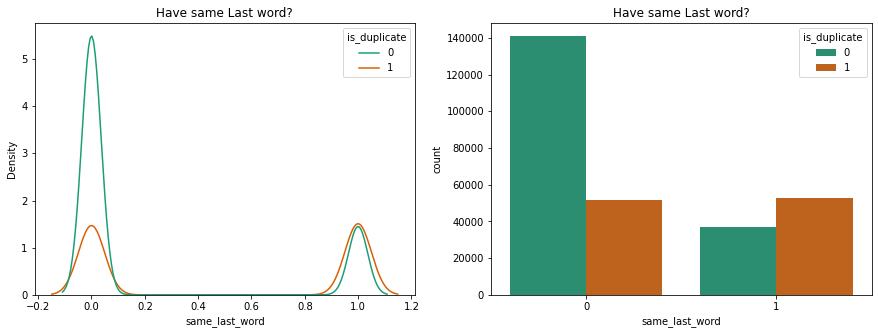

In [12]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Have same Last word?')
sns.kdeplot(data['same_last_word'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Have same Last word?')
sns.countplot(x=data['same_last_word'], hue=data.is_duplicate, palette="Dark2", ax=ax[1])
plt.show()

In [ ]:
modelST = SentenceTransformer('paraphrase-mpnet-base-v2')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.70k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/594 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
def getBertEmbeddings(data, filename):
    batch = 20000
    with open(filename, 'wb') as f:
        while(len(data)):
            tempdata = data[:batch]
            data = data[batch:]
            tempembed = modelST.encode(tempdata.values, device='cuda')
            np.save(f, tempembed, allow_pickle=True)
#             time.sleep(60) # for gpu heating issue
            

In [ ]:
getBertEmbeddings(data.question1_final, "/content/temp_train_question1_sentenceBERT.npy")

In [ ]:
!cp temp_train_question1_sentenceBERT.npy /content/drive/MyDrive/Quora-Questions/results

In [ ]:
getBertEmbeddings(data.question2_final, "/content/temp_train_question2_sentenceBERT.npy")

In [ ]:
!cp temp_train_question2_sentenceBERT.npy /content/drive/MyDrive/Quora-Questions/results

In [ ]:
getBertEmbeddings(test.question1_final, "/content/temp_test_question1_sentenceBERT.npy")
# !cp temp_test_question1_sentenceBERT.npy /content/drive/MyDrive/Quora-Questions/results

In [ ]:
!cp temp_test_question1_sentenceBERT.npy /content/drive/MyDrive/Quora-Questions/results

In [ ]:
getBertEmbeddings(test.question2_final, "/content/temp_test_question2_sentenceBERT.npy")


In [ ]:
!cp temp_test_question2_sentenceBERT.npy /content/drive/MyDrive/Quora-Questions/results

In [ ]:
!zip -r '/content/temp_test_question2_sentenceBERT.zip' '/content/temp_test_question2_sentenceBERT.npy' 


  adding: content/temp_test_question2_sentenceBERT.npy (deflated 7%)
